# Dementia Prediction
The objective is to use an ensemble model which will be able to predict whether a person is likely to have dementia or not given their medical records. Various ensemble model i.e. either bagging, stacking or boosting models will be tested against this dataset to find the one which will be best suited for this problem, so that given the symptoms we can predict the outcome of the patient before hand so that precautionary measures can be taken
___

* Type of Machine Learning Method
    * Supervised Learning
        * Classfication
            * Bagging -Random Forest
                * Accuracy - 85.29%
                * F1 Score - 82.14%
                * Recall - 85.19%
            * Stacking - Decision Trees, Naives Bayes, KNN
                * Accuracy - 85.29%
                * F1 Score - 80.77%
                * Recall - 77.78%
            * Boosting -  XGBoost
                * Accuracy - 86.76%
                * F1 Score - 83.64%
                * Recall - 85.19%
___
* Dataset Used
     * Data was gotten from [Kaggle]()
___

### Steps to Solve Problem
* Import Dataset and Libraries
* Data Preprocessing
    * Dropping Unuseful features
    * Train / Test Data split
    * Feature Engineering
    * Missing Data Imputation
    * Feature Scaling
* Model Build
    * Model Initiation and Fitting
    * Test predictions
* Model Perfromance
    * Recall
    * Case Prediction
        


## Import Dataset and Libraries

Import Libraries

In [ ]:
import pandas as pd # for data manipulation
import numpy as np # for numerical analysis
import joblib

# for plotting graphs
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Style settings
%matplotlib inline
sns.set_style("darkgrid")

Import Dataset

In [ ]:
dementia = pd.read_csv("dementia_dataset.csv")

In [ ]:
# check first 5 rows of data
dementia.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Check basic information of the dataset

In [ ]:
dementia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


## Data Preprocessing

### Feature Engineering

Mapping Ordinal values to numerical values

In [ ]:
group = {
    "Nondemented" : 0,
    "Demented" : 1,
    "Converted" : 2
}
dementia["Group"] = dementia["Group"].map(group)

In [ ]:
gender = {
    "M" : 1,
    "F" : 0
}
dementia["M/F"] = dementia["M/F"].map(gender)

Correlations

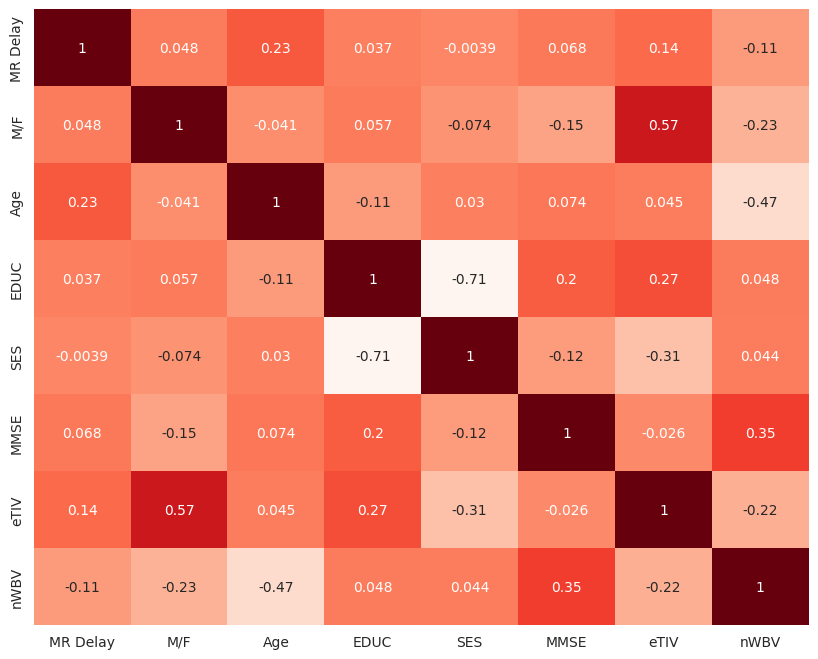

In [ ]:
plt.figure(figsize=[10, 8])
sns.heatmap(dementia.corr(), annot=True, cbar=False, cmap="Reds");
# (MR delay-Visit*), (educ-ses), (etiv-asf*) high correlated

The relationship between eTIV and ASF is almost perfectly correlated negatively, which may be the cause of the high correlation

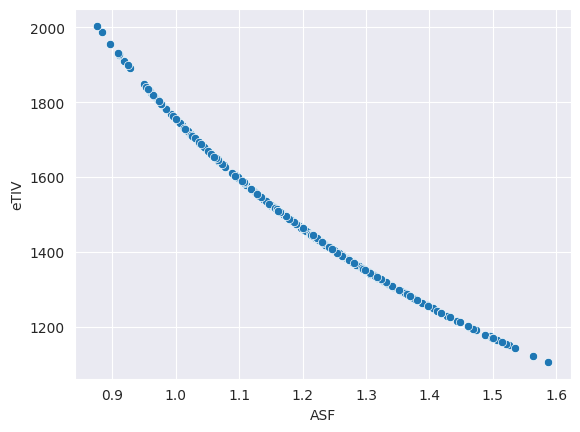

In [ ]:
sns.scatterplot(data=dementia, y="eTIV", x="ASF");

As we can see below whenever the number of visits is 1, the MR Delay equals 0

In [ ]:
dementia[dementia["Visit"] == 1]["MR Delay"].sample(10)

189    0
156    0
13     0
123    0
320    0
279    0
227    0
288    0
161    0
84     0
Name: MR Delay, dtype: int64

Dropping highly correlated data

In [ ]:
dementia.drop(["Visit", "ASF"], axis=1, inplace=True)

Also whenever the CDR feature equals to 1 or 0 its maps to Demented and Non-demented respectively, this column will be dropped to make the model more intelligent

In [ ]:
dementia[dementia["CDR"] == 1]["Group"].sample(10)

99     1
238    1
358    1
101    1
250    1
226    1
357    1
94     1
11     1
188    1
Name: Group, dtype: int64

All patients are right-handed so this feature isnt useful

In [ ]:
dementia["Hand"].value_counts()

R    373
Name: Hand, dtype: int64

Data Shuffle

In [ ]:
dementia = dementia.sample(frac=1, random_state=11).copy()

Dropping unuseful features
* Subject ID - id of pateint
* MRI ID - id of mri scan for each patient
* Hand - all patients are right handed

In [ ]:
dementia.drop(["Subject ID", "MRI ID", "Hand", "CDR"], axis=1, inplace=True)

Focus of pateint is Demented or Not Demented, so converted patients are not needed

In [ ]:
mask = dementia.loc[dementia["Group"] == 2].index
dementia.drop(mask, inplace=True)

### Data Split

In [ ]:
from sklearn.model_selection import train_test_split
X = dementia.drop("Group", axis=1)
y = dementia["Group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

Rows and instances in train and test set respectively

In [ ]:
X_train.shape, X_test.shape

((268, 8), (68, 8))

In [ ]:
# Renaming X_train to demnetia
dementia = X_train.copy()
dementia

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV
243,1345,1,76,20,2.0,30.0,1823,0.739
224,675,1,87,12,4.0,30.0,1762,0.718
314,0,0,78,18,1.0,30.0,1243,0.748
68,0,0,69,13,4.0,30.0,1359,0.789
142,451,1,68,12,4.0,29.0,1438,0.738
...,...,...,...,...,...,...,...,...
255,597,0,88,16,3.0,30.0,1295,0.744
41,0,0,61,16,3.0,30.0,1313,0.805
276,539,0,71,11,4.0,28.0,1284,0.741
94,575,0,85,15,2.0,22.0,1483,0.748


Extracting numerical features

In [ ]:
numerical = [col for col in dementia.columns if dementia[col].dtype != "O"]

### Missing data Imputation

Checking features that have missing data

In [ ]:
dementia.isna().sum()

MR Delay     0
M/F          0
Age          0
EDUC         0
SES         14
MMSE         0
eTIV         0
nWBV         0
dtype: int64

Importing library used for handling missing data

In [ ]:
from sklearn.impute import SimpleImputer

Using median to replace missing values as the data contains outliers

In [ ]:
imputer = SimpleImputer(strategy="median")

Imputing the data

In [ ]:
imputer.fit(dementia[numerical])
dementia[numerical] = imputer.transform(dementia[numerical])

Checking features that have missing data

In [ ]:
dementia.isna().sum()

MR Delay    0
M/F         0
Age         0
EDUC        0
SES         0
MMSE        0
eTIV        0
nWBV        0
dtype: int64

### Feature Scaling

Extracting features that will be scaled

In [ ]:
numerical_scale = ['MR Delay','Age','EDUC','SES','MMSE','eTIV','nWBV']

Importing library for scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

Scaling features to a range of -3 to 3 to boost model performance

In [ ]:
scaler = StandardScaler()
scaler.fit(dementia[numerical_scale])
dementia[numerical_scale] = scaler.transform(dementia[numerical_scale])

In [ ]:
joblib.dump(scaler, "scaler_joblib")

['scaler_joblib']

In [ ]:
dementia

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV
243,1.153824,1.0,-0.048614,1.984618,-0.537880,0.722419,1.757963,0.221513
224,0.104165,1.0,1.384521,-0.861550,1.322144,0.722419,1.430327,-0.348265
314,-0.953327,0.0,0.211956,1.273076,-1.467892,0.722419,-1.357257,0.465703
68,-0.953327,0.0,-0.960609,-0.505779,1.322144,0.722419,-0.734213,1.578127
142,-0.246766,1.0,-1.090894,-0.861550,1.322144,0.468340,-0.309899,0.194381
...,...,...,...,...,...,...,...,...
255,-0.018034,0.0,1.514806,0.561534,0.392132,0.722419,-1.077961,0.357174
41,-0.953327,0.0,-2.002889,0.561534,0.392132,0.722419,-0.981282,2.012244
276,-0.108900,0.0,-0.700039,-1.217321,1.322144,0.214261,-1.137043,0.275777
94,-0.052500,0.0,1.123951,0.205763,-0.537880,-1.310215,-0.068201,0.465703


## Model Building

In [ ]:
# renaming data to X_train
X_train = dementia.copy()

Preprocessing Validation data

In [ ]:
X_test[numerical] = imputer.transform(X_test[numerical])

In [ ]:
X_test[numerical_scale] = scaler.transform(X_test[numerical_scale])

In [ ]:
X_test.head()

,MR Delay,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV
213,0.538128,0.0,-0.309184,1.273076,-0.537880,0.722419,-0.513999,0.574233
28,0.154298,1.0,1.775376,-2.284634,1.322144,-1.056135,0.925447,-2.301790
87,-0.184099,0.0,-0.439469,-0.861550,1.322144,-0.293898,-0.240075,0.709894
328,0.019566,1.0,0.993666,-0.150008,-0.537880,-1.310215,0.291661,-1.786276
222,-0.224832,1.0,-0.700039,0.561534,-1.467892,-2.580611,0.356114,-1.243631


### Bagging

Importing library for bagging .i.e Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
bagger = RandomForestClassifier(random_state=51, n_jobs=-1, n_estimators=40, max_depth=15)

In [ ]:
bagger.fit(X_train, y_train)
predictions = bagger.predict(X_test)

#### Bagging Performance

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,  recall_score

In [ ]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %")
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 85.29 %
The f1 score is 82.14 %
The recall is 85.19 %


Confusion Matrix
|   | 0  | 1  |
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

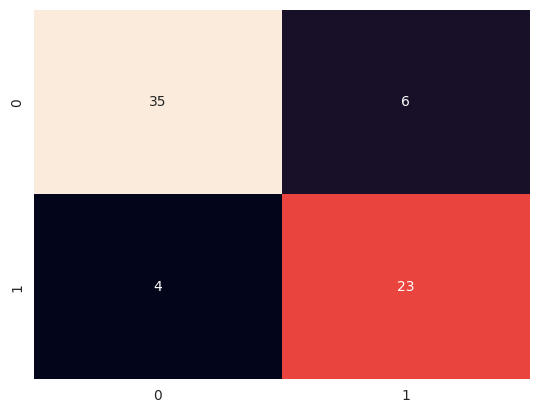

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
# TN   FP
# FN*   TP - Recall

### Stacking


Algorithms used for stacking
*   Decision Tree
*   Naive Bayes
*   KNN

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=4, max_leaf_nodes=4, random_state=51)),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=10))]

In [ ]:
stacker = StackingClassifier(estimators)

In [ ]:
stacker.fit(X_train, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=4,
                                                       max_leaf_nodes=4,
                                                       random_state=51)),
                               ('nb', GaussianNB()),
                               ('knn', KNeighborsClassifier(n_neighbors=10))])

In [ ]:
predictions = stacker.predict(X_test)

#### Stacking Performance

In [ ]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %")
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 85.29 %
The f1 score is 80.77 %
The recall is 77.78 %


Confusion Matrix
|   | 0  | 1  |
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

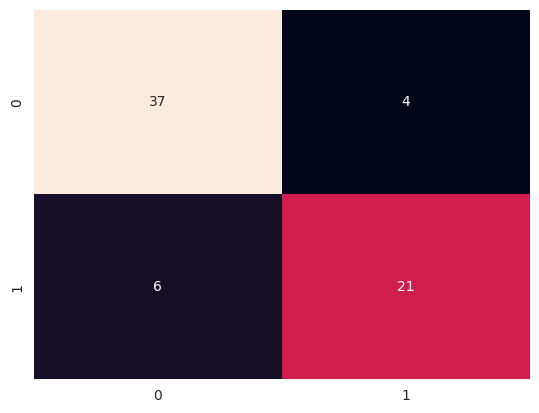

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
# TN   FP
# FN*   TP - Recall

### Boosting

In [ ]:
from xgboost import XGBClassifier

In [ ]:
booster = XGBClassifier(random_state=51, n_estimators=60, max_depth=23, learning_rate=0.5)

In [ ]:
booster.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=23, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=51, ...)

In [ ]:
predictions = booster.predict(X_test)

#### Boosting Performance

In [ ]:
print(f"The accuracy is {accuracy_score(y_test, predictions) * 100:.2f} %")
print(f"The f1 score is {f1_score(y_test, predictions) * 100:.2f} %")
print(f"The recall is {recall_score(y_test, predictions) * 100:.2f} %")

The accuracy is 88.24 %
The f1 score is 85.19 %
The recall is 85.19 %


Confusion Matrix
|   | 0  | 1  |
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

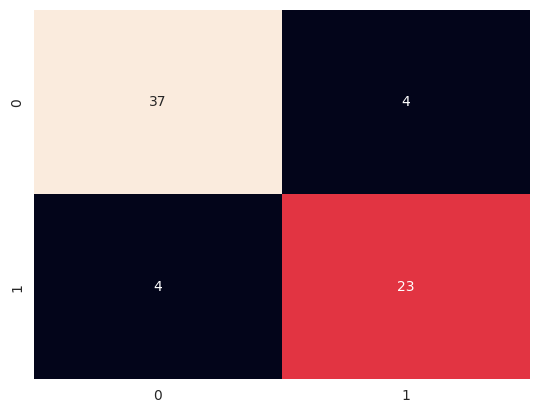

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cbar=False);
# TN   FP
# FN*   TP - Recall

### Saving The Model

In [ ]:
joblib.dump(booster, "model_joblib")

['model_joblib']